<a href="https://colab.research.google.com/github/Kalisa21/chatbot/blob/main/Healthcare_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

Importing dependencies


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
from transformers import AutoTokenizer
from datasets import Dataset
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Loading the dataset and displaying a wordcloud to show the most abundant words

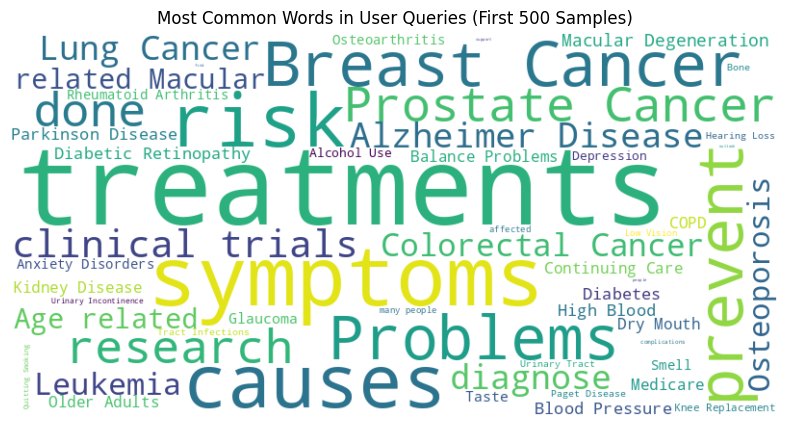

In [42]:
import pandas as pd
from datasets import load_dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset (first 500 samples only)
dataset = load_dataset("Nagasai0511/llama3_medquad_instruct_dataset", split="train[:500]")

# Extract 'input' text from the dataset (user queries)
user_texts = [sample["input"] for sample in dataset if "input" in sample]

# Join all text for the word cloud
all_text = " ".join(user_texts)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in User Queries (First 500 Samples)")
plt.show()


Filter the dataset to create question answer pairs

In [4]:
# Prepare conversation pairs
conversations = []
for sample in dataset:
    user_text = sample["input"]
    bot_response = sample["output"]
    conversations.append(f"User: {user_text}\nBot: {bot_response}")

# Show a sample conversation (e.g., index 3)
print(conversations[3])

User: What are the treatments for Glaucoma ?
Bot: Although open-angle glaucoma cannot be cured, it can usually be controlled. While treatments may save remaining vision, they do not improve sight already lost from glaucoma. The most common treatments for glaucoma are medication and surgery. Medications  Medications for glaucoma may be either in the form of eye drops or pills. Some drugs reduce pressure by slowing the flow of fluid into the eye. Others help to improve fluid drainage. (Watch the video to learn more about coping with glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) For most people with glaucoma, regular use of medications will control the increased fluid pressure. But, these drugs may stop working over time. Or, they may cause side effects. If a problem occurs, the eye care professional may select other drugs, change the dose, or suggest other ways to deal with the prob

Loading the tokenizer and converting our dataset to a compatible hugging face dataset

In [5]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer

# Load the first 500 rows of the dataset
raw_dataset = load_dataset("Nagasai0511/llama3_medquad_instruct_dataset", split="train[:500]")

# Prepare conversation pairs using input (user) and output (bot)
conversations = [f"User: {sample['input']}\nBot: {sample['output']}" for sample in raw_dataset]

# Load GPT-2 tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set padding token to eos_token (required for GPT-2)
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the conversation data
tokenized_data = tokenizer(conversations, padding=True, truncation=True, return_tensors="pt")

# Convert to Hugging Face Dataset
dataset = Dataset.from_dict({
    "input_ids": tokenized_data["input_ids"],
    "attention_mask": tokenized_data["attention_mask"]
})

# Print a sample
print(dataset[0])

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'input_ids': [12982, 25, 1867, 318, 357, 533, 8, 2671, 559, 785, 64, 5633, 198, 20630, 25, 2671, 559, 785, 64, 318, 257, 1448, 286, 10040, 326, 460, 2465, 262, 4151, 338, 43151, 16384, 290, 1255, 287, 5761, 2994, 290, 37673, 13, 2893, 1278, 559, 785, 64, 460, 5587, 2687, 11, 262, 2526, 318, 881, 3744, 329, 661, 625, 3126, 13, 1374, 2671, 559, 785, 64, 6013, 82, 220, 1318, 389, 1811, 1180, 3858, 286, 1278, 559, 785, 64, 13, 4042, 286, 777, 6211, 262, 37664, 1080, 1626, 262, 4151, 13, 1629, 262, 2166, 286, 262, 4151, 612, 318, 257, 1402, 2272, 1444, 262, 32700, 11847, 13, 317, 1598, 11711, 15623, 832, 428, 11847, 290, 7365, 956, 290, 31219, 5614, 262, 6716, 21379, 13, 357, 10723, 262, 2008, 284, 2193, 517, 546, 1278, 559, 785, 64, 13, 1675, 27475, 262, 2008, 11, 3904, 262, 28103, 287, 262, 2793, 826, 12, 4993, 5228, 13, 1675, 4646, 262, 2008, 11, 1803, 262, 14473, 357, 47051, 8, 4936, 319, 534, 10586, 2014, 554, 1278, 559, 785, 64, 11, 329, 991, 6439, 3840, 11, 262, 11711, 44368, 1165, 

loading the model and setting up the training parameters

In [12]:
# Load GPT-2 tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, EarlyStoppingCallback
from datasets import load_dataset, Dataset
import torch
import os

# Disable WandB
os.environ["WANDB_DISABLED"] = "true"

# Load the first 500 rows from the dataset
raw_dataset = load_dataset("Nagasai0511/llama3_medquad_instruct_dataset", split="train[:500]")

# Prepare conversation pairs
conversations = [f"User: {sample['input']}\nBot: {sample['output']}" for sample in raw_dataset]

# Load tokenizer and set pad token
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Tokenize conversations
tokenized_data = tokenizer(conversations, padding=True, truncation=True, return_tensors="pt")

# Convert tokenized tensors into a Hugging Face Dataset
dataset = Dataset.from_dict({
    "input_ids": tokenized_data["input_ids"],
    "attention_mask": tokenized_data["attention_mask"]
})

# Split dataset into training and evaluation sets
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]


# Load GPT-2 model
model = AutoModelForCausalLM.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    fp16=True,
    report_to="none"
)

# Data collator for causal LM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)


# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset, # Pass the evaluation dataset here
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/tmp/ipython-input-12-2841598747.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,2.136100,1.989654
2,1.943600,1.911671
3,1.810100,1.875251
4,1.691900,1.856601
5,1.678600,1.852233


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=500, training_loss=1.8729156188964844, metrics={'train_runtime': 392.0579, 'train_samples_per_second': 5.101, 'train_steps_per_second': 1.275, 'total_flos': 1045168128000000.0, 'train_loss': 1.8729156188964844, 'epoch': 5.0})

In [14]:
# Save model and tokenizer
model.save_pretrained("/content/healthbot")
tokenizer.save_pretrained("/content/healthbot")

('/content/healthbot/tokenizer_config.json',
 '/content/healthbot/special_tokens_map.json',
 '/content/healthbot/vocab.json',
 '/content/healthbot/merges.txt',
 '/content/healthbot/added_tokens.json',
 '/content/healthbot/tokenizer.json')

In [36]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load saved model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/healthbot")
model = AutoModelForCausalLM.from_pretrained("/content/healthbot")

In [37]:
def test_chatbot(user_input, max_length=100):
    prompt = f"User: {user_input}\nBot:"
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    output_ids = model.generate(
        input_ids,
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )

    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    bot_reply = response.split("Bot:")[-1].strip()
    print(f" Chatbot Reply: {bot_reply}")

In [38]:
test_chatbot("How can I prevent a cold?")

 Chatbot Reply: With proper care, your doctor can prevent a cold. Treating the symptoms of colds is important. Here are some tips to help you manage the symptoms of colds. - Ask your doctor about symptoms.  - Ask about your doctor's opinion on what you can do to prevent a cold.  - If you notice symptoms that you cannot control, talk to your doctor.  - See a doctor when you are ready to go to


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!cp -r healthbot /content/drive/MyDrive/

In [22]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00


In [21]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

# Define test samples
test_samples = [
    {"question": "What causes glaucoma", "answer": "Glaucoma is usually caused by high pressure in the eye."},
    {"question": "What is a healthy blood pressure?", "answer": "A normal blood pressure level is less than 120/80 mmHg."},
    {"question": "Tell me about skin cancer", "answer": "Skin cancer is the abnormal growth of skin cells."},
    {"question": "Is mental health genetic?", "answer": "Some mental illnesses have a genetic component."},
]

bleu_scores = []
f1_scores = []

for sample in test_samples:
    prompt = f"User: {sample['question']}\nBot:"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    output = model.generate(input_ids, max_length=100, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    prediction = generated_text.split("Bot:")[-1].strip()

    ref = sample['answer'].split()
    pred = prediction.split()

    bleu = sentence_bleu([ref], pred)
    bleu_scores.append(bleu)

    common = set(ref) & set(pred)
    precision = len(common) / len(pred) if pred else 0
    recall = len(common) / len(ref) if ref else 0
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    f1_scores.append(f1)

print(f" Average BLEU score: {np.mean(bleu_scores):.4f}")
print(f" Average F1 score: {np.mean(f1_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

🔍 Average BLEU score: 0.0000
🔍 Average F1 score: 0.1016


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [23]:
from transformers import pipeline

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define the domain label
domain_label = "healthcare"

# Function to detect domain relevance
def is_healthcare_query(text, threshold=0.7):
    result = classifier(text, candidate_labels=[domain_label])
    score = result["scores"][0]
    is_relevant = score >= threshold
    return is_relevant, score


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [39]:
query = "What causes glaucoma"
is_relevant, confidence = is_healthcare_query(query)

if is_relevant:
    print(f" In-domain ({confidence:.2f}) → proceed to GPT-2")
else:
    print(f" Out-of-domain ({confidence:.2f}) → show rejection message")


 In-domain (0.82) → proceed to GPT-2


In [40]:
query = "What is the weather in kigali"
is_relevant, confidence = is_healthcare_query(query)

if is_relevant:
    print(f" In-domain ({confidence:.2f}) → proceed to GPT-2")
else:
    print(f" Out-of-domain ({confidence:.2f}) → show rejection message")


 Out-of-domain (0.00) → show rejection message


In [41]:
import gradio as gr

# Chatbot logic using zero-shot + GPT-2
def healthcare_chatbot(user_input):
    # Check if the query is healthcare-related
    is_relevant, confidence = is_healthcare_query(user_input)

    # Format confidence as a percentage
    confidence_pct = f"{confidence * 100:.2f}%"

    if is_relevant:
        # Generate GPT-2 response
        prompt = f"User: {user_input}\nBot:"
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)

        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_length=100,
                pad_token_id=tokenizer.eos_token_id,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7
            )

        decoded = tokenizer.decode(output[0], skip_special_tokens=True)
        bot_reply = decoded.split("Bot:")[-1].strip()
        return f" GPT-2: {bot_reply}\n\n Domain confidence: {confidence_pct}"
    else:
        return f" Sorry, I can only answer healthcare-related questions.\n\nDetected domain confidence: {confidence_pct}"

# Build Gradio interface
gr.Interface(
    fn=healthcare_chatbot,
    inputs=gr.Textbox(lines=2, placeholder="Ask a healthcare question..."),
    outputs="text",
    title="🩺 Healthcare Chatbot (GPT-2 + Zero-Shot Filter)",
    description="This chatbot answers healthcare questions using GPT-2. Out-of-domain queries are rejected using BART zero-shot classification.",
    theme="soft"
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d7aca3b92761ad6f5d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
